In [1]:
import sys
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from torch.distributions.categorical import Categorical
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR

import numpy as np
import pickle as pkl

from tqdm.notebook import tqdm
import networkx as nx

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit import RDLogger   

%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

from IPython.display import SVG

from collections import defaultdict
import multiprocessing as mp
from statistics import stdev, mean
from pathlib import Path
import pickle as pkl
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import umap
import umap.plot

from eval_tools.eval_molecules import calc_mol_activity, predict_probability
from joblib import load


In [2]:
NUM_CPU = 6
SEED = 3287450

In [3]:
torch.manual_seed(SEED)
torch.cuda.empty_cache()
sns.set(style='white', context='notebook', rc={'figure.figsize':(7,5)})
np.set_printoptions(threshold=sys.maxsize)
RDLogger.DisableLog('rdApp.*') 

In [4]:
def save(thing, path):
    with open(path, 'wb') as fp:
        pkl.dump(thing, fp)
    print(f'saved [{type(thing)}] to {path}')

# Lipinski Dataset Processing

In [106]:
EVAL_MODEL = load('./eval_tools/chembl_25/models/1uM/mNB_1uM_all.pkl') # used for activity prediction

/home/cerber/.conda/envs/pymatch/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning:

Trying to unpickle estimator MultinomialNB from version 0.19.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

/home/cerber/.conda/envs/pymatch/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning:

Trying to unpickle estimator LabelBinarizer from version 0.19.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

/home/cerber/.conda/envs/pymatch/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning:

Trying to unpickle estimator OneVsRestClassifier from version 0.19.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.



In [5]:
!ls ./data

lipinski


In [6]:
GO_TOKEN = 'G'
END_TOKEN = '\n'
PAD_TOKEN = 'A'

DATA_PATH = Path('./data/lipinski/')

In [7]:
def load_smiles(path):
    all_smiles = []
    with open(path) as fp:
        for line in tqdm(fp.readlines()):
            all_smiles += [line[:-1]]
    return all_smiles

In [8]:
def process_smiles_file(path, test_split=0.15):
    all_smiles = []
    with open(path) as fp:
        for line in tqdm(fp.readlines()):
            all_smiles += [GO_TOKEN + line]
    size = len(all_smiles)
    split = int(size * test_split)
    return all_smiles[split:] ,  all_smiles[:split]

In [9]:
def get_valid(smiles):
    """
    get_valid(smiles):
        - returns % of valid smiles
    """
    valid = []
    
    for m in tqdm(map(Chem.MolFromSmiles, smiles), total=len(smiles)):
        if m:
            valid += [m]
        
    return valid, len(valid) / len(smiles), 
    

In [10]:
QED_PROPERTIES = ['MW', 'ALOGP', 'HBA', 'HBD', 'PSA', 'ROTB', 'AROM', 'ALERTS']
QED_DF_COLUMNS = ['ID', 'SMILES', *QED_PROPERTIES]

In [11]:
def get_qed_mol(m):
    mol_prop = QED.properties(m)
    mol_prop_num = [getattr(mol_prop, attr) for attr in QED_PROPERTIES]
    return mol_prop_num

In [12]:
def make_qed_df(mols, ID, processes=NUM_CPU):
    with mp.Pool(processes=processes) as pool:
        results = pool.map(get_qed_mol, mols)
    rows = []
    for m, results in tqdm(zip(mols, results)):
        row = [ID, Chem.MolToSmiles(m)] + results
        rows += [row]
    
    return pd.DataFrame(data=rows, columns=QED_DF_COLUMNS)

In [13]:
# lesss get her done (but once)

# dl_smiles = load_smiles(DATA_PATH / 'druglike_lipinski.smi')
# dl_mols, validity = get_valid(dl_smiles)
# dl_df = make_qed_df(dl_mols, 'DRUGLIKE')
# dl_df.to_pickle(DATA_PATH / 'druglike-qed-data.pkl')
# print('Drug-like DataFrame ready. ')

# a_smiles = load_smiles(DATA_PATH / 'active_lipinski.smi')
# a_mols, validity = get_valid(a_smiles)
# a_df = make_qed_df(a_mols, 'ACTIVE')
# a_df.to_pickle(DATA_PATH / 'active-qed-data.pkl')

# print('Active DataFrame ready. ')

# va_smiles = load_smiles(DATA_PATH / 'very_active_lipinski.smi')
# va_mols, validity = get_valid(va_smiles)
# va_df = make_qed_df(va_mols, 'VERY ACTIVE')
# va_df.to_pickle(DATA_PATH / 'very-active-qed-data.pkl')

# print('Very Active DataFrame ready. ')

In [14]:
!ls data/lipinski

active_lipinski.smi		 druglike-qed-data.pkl
active-qed-data.pkl		 gcpn_smiles.500.smi
all_lipinski.smi		 lstm_smiles.500.smi
druglike_lipinski_100k.smi	 qed_df_full.pickle
druglike_lipinski_10k.smi	 qed_df.pickle
druglike_lipinski_1k.smi	 qed_df_small.activity.pickle
druglike_lipinski_50k.test.smi	 results
druglike_lipinski_50k.train.smi  very_active_lipinski.smi
druglike_lipinski.smi		 very-active-qed-data.pkl


In [15]:
dl_df = pd.read_pickle(DATA_PATH / 'druglike-qed-data.pkl')
a_df = pd.read_pickle(DATA_PATH / 'active-qed-data.pkl')
va_df = pd.read_pickle(DATA_PATH / 'very-active-qed-data.pkl')

## Lipinski QED Properties

In [16]:
QED_PROPERTIES

['MW', 'ALOGP', 'HBA', 'HBD', 'PSA', 'ROTB', 'AROM', 'ALERTS']

In [17]:
def make_qed_plots(*dfs):
    fig, axs = plt.subplots(ncols=4,nrows=4)
    colours = ['c', 'g', 'y']
    for i in range(4):
        for j in range(4):
            var = QED_PROPERTIES[i+j]
            for  df, colour in zip(dfs, colours):
                sns.distplot(df[var].values, label=var, ax=axs[i,j],color=colour)
            axs[i,j].title.set_text(f'{var}')


<IPython.core.display.Javascript object>


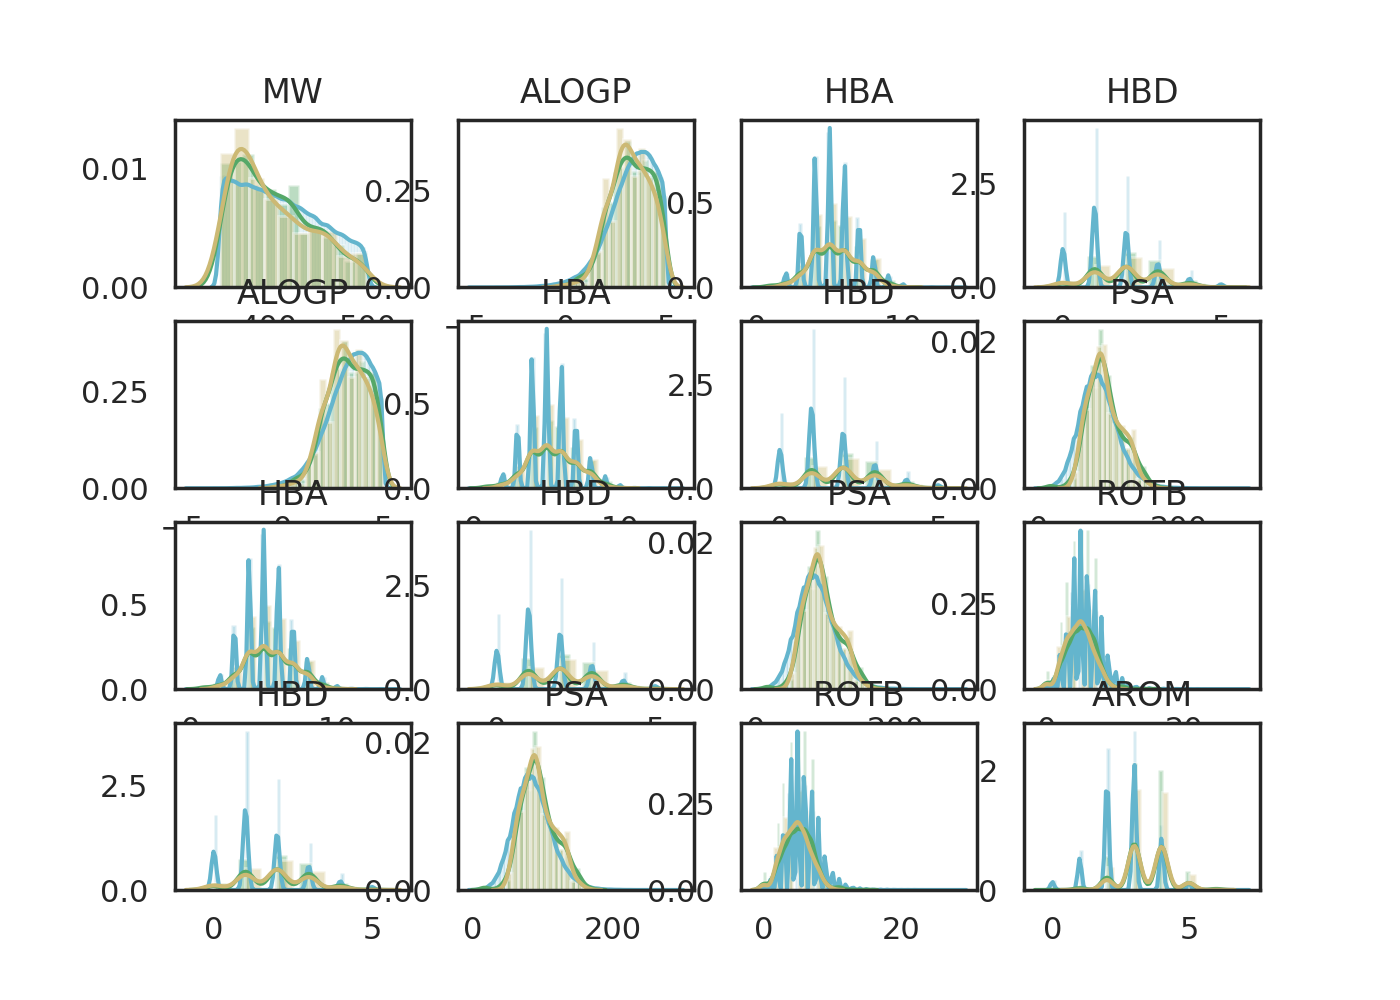

In [18]:
make_qed_plots(dl_df, a_df, va_df)

In [19]:
dl_df.sample(10)

,ID,SMILES,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS
493973,DRUGLIKE,CC(O)(C(=O)Nc1ccc(S(=O)(=O)c2ccc(Br)cc2)cc1)C(...,452.248,3.53370,4,2,83.47,4,2,0
563043,DRUGLIKE,CCC[C@@H](C(=O)N[C@H](C#N)CC(N)=O)N(Cc1ccc(-c2...,474.558,2.30678,5,2,133.36,11,2,0
175972,DRUGLIKE,C=CCN1C(=O)CS/C1=N/NC(=O)C(O)(c1ccccc1)c1ccccc1,381.457,2.07110,4,2,82.00,6,2,2
427220,DRUGLIKE,CN(c1ncccn1)S(=O)(=O)c1ccc(NC(=O)c2cc(-c3ccccc...,434.481,2.94410,6,2,120.94,6,4,0
153234,DRUGLIKE,CCCS(=O)(=O)Nc1ccc(F)c(-c2ccc3cc(N)ncc3c2)c1F,377.416,3.91390,4,2,85.08,5,3,0
389498,DRUGLIKE,COc1ccc(-c2cc(C(F)(F)F)nc(SCC(=O)N3CCC(C)CC3)n...,425.476,4.52160,5,0,55.32,5,2,2
193405,DRUGLIKE,O=C(O[C@H]1C[C@H](n2cc(F)c(=O)[nH]c2=O)O[C@@H]...,384.747,0.83450,6,2,110.62,4,2,1
80728,DRUGLIKE,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-n3cnc([N+](=O)[O-...,364.264,2.09170,6,1,120.26,4,3,2
584468,DRUGLIKE,COCCCNC(=O)c1cc(-c2cccnc2)nc2ccc(S(=O)(=O)N3CC...,482.606,3.62780,6,1,101.49,8,3,1
527038,DRUGLIKE,COc1ccc(C(=O)N[C@@H](CC(=O)O)c2ccccc2F)nc1-c1c...,462.399,4.86090,5,2,88.52,7,3,1


In [20]:
def make_qed_embed(*dfs, n=2, n_neigh=50, groupby='ID'):
    df = pd.concat(dfs,ignore_index=True)
    data = df[QED_PROPERTIES].values.astype(np.float64)
    reducer = umap.UMAP(n_components=n,n_neighbors=n_neigh).fit(data)
    embedding = reducer.transform(data)
    
    embed_df = pd.DataFrame(data=embedding, columns = [f'COMP{i}' for i in range(n)])
    embed_df[groupby] = df[groupby]
    return embed_df, reducer

In [23]:
qed_embed_df, qed_reducer  = make_qed_embed(dl_df.sample(10_000).reindex(), a_df, va_df, n=3)

In [24]:
qed_embed_fig = px.scatter_3d(qed_embed_df, x='COMP0', y='COMP1', z='COMP2',
                    color='ID', width=900, height=1000)
qed_embed_fig.show()

In [ ]:
qed_embed_fig = px.scatter(qed_embed_df, x='COMP0', y='COMP1', color="ID")
qed_embed_fig.show()

In [ ]:
# umap.plot.output_notebook()
# p = umap.plot.interactive(mapper, labels=fmnist.target[:30000], point_size=2)
# umap.plot.show(p)


## Morgan Fingerprint Experiments

In [ ]:
def get_morgan_fp_mol(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=int(100))
    res = np.zeros(len(fp), np.int32)
    DataStructs.ConvertToNumpyArray(fp, res)
    return res

In [ ]:
def get_morgan_fp_df(df, size=None):
    if size is None:
        size = len(df)
    sample = df.sample(size)
    smiles = sample['SMILES'].values.tolist()
    fps = []
    
    for s in tqdm(smiles):
        mol = Chem.MolFromSmiles(s)
        fp = get_morgan_fp_mol(mol)
        fps += [fp]
        
    return fps

In [ ]:
dl_fps = get_morgan_fp_df(dl_df, 10_000)
a_fps = get_morgan_fp_df(a_df)
va_fps = get_morgan_fp_df(va_df)


In [ ]:
all_fps = dl_fps + a_fps + va_fps
all_fps = np.array(all_fps)

In [ ]:
all_fps.shape

In [ ]:
fp_embedding = umap.UMAP(n_components=3).fit_transform(all_fps)

In [ ]:
fp_embedding.shape

In [ ]:
fp_embed_df = pd.DataFrame(data=fp_embedding, columns= ['COMP1','COMP2','COMP3'])

In [ ]:
fp_embed_df['ID'] = labels

In [ ]:
fp_embed_fig = px.scatter_3d(fp_embed_df, x='COMP1', y='COMP2', z='COMP3',
                    color='ID',width=900, height=1000)
fp_embed_fig.show()

In [ ]:
labels = np.array(['druglike'] * len(dl_fps) + ['active'] * len(a_fps) + ['very active'] * len(va_fps))

In [ ]:
umap.plot.points(fp_reducer, labels=labels)


# Model Loading and Sampling

In [25]:
MAX_SYM = 136
NUM_SYM = 41

In [26]:
runid = 'results/zebra-run'

In [27]:
SYM_TO_ID = load(DATA_PATH / runid / 'SYM_TO_ID')
ID_TO_SYM = load(DATA_PATH / runid / 'ID_TO_SYM')

In [28]:
def encode(smiles):
    """
    encode(simles): 
        - takes in a variable length smiles string (up to MAX_SYM) 
          and outputs a fixed size vector (MAX_SYM by NUM_SYM)
        
    """
    x = np.zeros((MAX_SYM, NUM_SYM))
    x_n = len(smiles)
    for i, sym in enumerate(smiles):
        x[i, SYM_TO_ID[sym]] = 1
    x[x_n:, SYM_TO_ID[PAD_TOKEN]] = 1
    return x, x_n

In [29]:
def decode(x):
    assert x.shape[1] == NUM_SYM
    smiles = ''
    for i in range(x.shape[0]):
        topi = np.argmax(x[i, :])
        smiles += ID_TO_SYM[topi]
    return smiles 

def decode_valid(x):
    s = decode(x)
    if s[0] == 'G':
        s = s[1:]
    return  s[:s.find(END_TOKEN)]

In [30]:
class SMILESDataset(torch.utils.data.Dataset):
    
    def __init__(self, smiles):
        self.all_smiles = smiles
        self.size = len(smiles)

    def __len__(self):
        return self.size
    
    def __getitem__(self, i):
        """
        __getitem__(self, i):
            - return 
        """
        x_i, x_n = encode(self.all_smiles[i])
        
        y_i = x_i[1:].copy()
        x_i = x_i[:-1].copy()
        
        return x_i, y_i, x_n
    

In [31]:
# plain LSTM model
class GeneratorLSTM(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size, embedding_size):
        super().__init__()
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=embedding_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True,
                            dropout=0.15)
        
        self.input_module = nn.Sequential(nn.Linear(input_size, 256),
                                         nn.ReLU(),
                                         nn.Dropout(0.10),
                                         nn.Linear(256, 512),
                                         nn.ReLU(),
                                         nn.Dropout(0.10),
                                         nn.Linear(512, embedding_size),
                                         nn.ReLU())
        
        self.output_module = nn.Sequential(nn.Linear(hidden_size , 256),
                                           nn.Dropout(0.10),
                                           nn.ReLU(),
                                           nn.Linear(256, output_size))

        self.hidden = None 

    def init_hidden(self, batch_size, cuda=True):

        ht = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))
        ct = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))

        if cuda:
            return ht.cuda(), ct.cuda()
        else:
            return ht, ct
            


    def forward(self, input_raw, pack=False, input_lens=None):
        """
        forward(self, input_raw, state):
             - input_raw = (bs, x_{i,t})
             - state = (ht, ct)
        """
        input_ = self.input_module(input_raw)
        
        if pack:
            input_ = pack_padded_sequence(input_, input_lens, batch_first=True)
            
        input_, self.hidden = self.lstm(input_, self.hidden)
        
        if pack: 
            input_ = pad_packed_sequence(input_, batch_first=True)[0]

            
        input_ = self.output_module(input_)
        return input_

In [32]:
def softmax_temp_sample(y_t, temperature = 1.0):
    prediction_vector = F.softmax(y_t / temperature, dim=-1)
    x_index_t = torch.multinomial(prediction_vector, 1)[:, 0]
    return x_index_t

In [34]:
def generate(model, test_samples=5, sample_f=softmax_temp_sample, temp=1, v=True):
    with torch.no_grad():
        model.eval()

        x = torch.zeros(test_samples, MAX_SYM, NUM_SYM).cuda()

        x[:, 0, SYM_TO_ID[GO_TOKEN]] = 1
        
        for i in range(MAX_SYM-1):
            model.hidden = model.init_hidden(batch_size=test_samples)
            
            pred = model(x, pack=True, input_lens=np.ones(test_samples)*(i+1))
            pred_idx = sample_f(pred[:,i,:])
            temp = torch.zeros(test_samples, MAX_SYM, NUM_SYM).cuda()
            for j in range(test_samples):
                temp[j, i+1, pred_idx[j]] = 1  
            x.add_(temp)

        if v: print('\n',10*'-' + 'GENERATED SMILES STRINGS' + 10*'-')
        smiles = []

        for j in range(test_samples):
            s = decode_valid(x[j].cpu().numpy())
            smiles += [s]

            if v: print(s)

        return smiles

In [44]:
def sample_with_weights(weights_dir, size, v=False):
    weights_path = weights_dir / 'model_dict.torch'
    model = GeneratorLSTM(input_size = NUM_SYM,
                      output_size = NUM_SYM, 
                      num_layers = 3, 
                      hidden_size = 512, 
                      embedding_size = 512)
    model.load_state_dict(torch.load(weights_path))
    model.cuda()
    return generate(model, test_samples=size, v=v)
    

In [45]:
! ls data/lipinski/results/zebra-run/phase-1

0-epoch-0-batch-nan-loss	 1-epoch-0-batch-nan-loss
0-epoch-10000-batch-0.4094-loss  1-epoch-10000-batch-0.4280-loss
0-epoch-1000-batch-0.8034-loss	 1-epoch-1000-batch-0.3844-loss
0-epoch-10500-batch-0.3988-loss  1-epoch-10500-batch-0.4025-loss
0-epoch-11000-batch-0.3938-loss  1-epoch-11000-batch-0.3528-loss
0-epoch-11500-batch-0.4645-loss  1-epoch-11500-batch-0.4226-loss
0-epoch-12000-batch-0.5405-loss  1-epoch-12000-batch-0.3028-loss
0-epoch-12500-batch-0.4236-loss  1-epoch-12500-batch-0.3928-loss
0-epoch-13000-batch-0.4088-loss  1-epoch-13000-batch-0.2638-loss
0-epoch-13500-batch-0.4573-loss  1-epoch-13500-batch-0.4856-loss
0-epoch-14000-batch-0.4762-loss  1-epoch-14000-batch-0.4519-loss
0-epoch-14500-batch-0.3924-loss  1-epoch-14500-batch-0.3850-loss
0-epoch-15000-batch-0.3272-loss  1-epoch-15000-batch-0.4239-loss
0-epoch-1500-batch-0.5716-loss	 1-epoch-1500-batch-0.3604-loss
0-epoch-15500-batch-0.4232-loss  1-epoch-15500-batch-0.4424-loss
0-epoch-16000-batch-0.4387-loss  1-epoch-16

In [46]:
novel_p1_smiles = sample_with_weights(DATA_PATH / runid / 'phase-1' / '1-epoch-END-batch', size=200)
novel_p2_smiles = sample_with_weights(DATA_PATH / runid / 'phase-2' / '1-epoch-END-batch', size=200)
novel_p3_smiles = sample_with_weights(DATA_PATH / runid / 'phase-3' / '1-epoch-END-batch', size=200)

# New Molecule Plotting & Evaluation

In [87]:
novel_p1_mols, validity = get_valid(novel_p1_smiles)
print(f'sampled from phase 1 with [{validity:.2f}%] validity')

novel_p2_mols, validity = get_valid(novel_p2_smiles)
print(f'sampled from phase 1 with [{validity:.2f}%] validity')

novel_p3_mols, validity = get_valid(novel_p3_smiles)
print(f'sampled from phase 1 with [{validity:.2f}%] validity')


sampled from phase 1 with [0.85%] validity



sampled from phase 1 with [0.84%] validity



sampled from phase 1 with [0.85%] validity


In [88]:
len(set(novel_p1_smiles)),len(set(novel_p2_smiles)),len(set(novel_p3_smiles))

(200, 200, 200)

In [89]:
len(set(novel_p1_smiles + novel_p2_smiles + novel_p3_smiles))

600

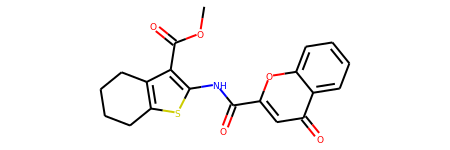

In [52]:
novel_p2_mols[5]

In [90]:
novel_p1_mol_activity = [calc_mol_activity(m, eval_model) for m in tqdm(novel_p1_mols)]
novel_p2_mol_activity = [calc_mol_activity(m, eval_model) for m in tqdm(novel_p2_mols)]
novel_p3_mol_activity = [calc_mol_activity(m, eval_model) for m in tqdm(novel_p3_mols)]

In [105]:
hist_data = []
hist_data.append([i[1] for i in novel_p1_mol_activity])
hist_data.append([i[1] for i in novel_p2_mol_activity])
hist_data.append([i[1] for i in novel_p3_mol_activity])

group_labels = ['phase 1','phase 2','phase 3']
colors = ['#835AF1', '#7FA6EE', '#B8F7D4']


activity_hist_fig = ff.create_distplot(hist_data, group_labels=group_labels,
                                       bin_size=0.05, colors=colors)
activity_hist_fig.show()

In [91]:
most_active_p1 = sorted(zip(novel_p1_mols, novel_p1_mol_activity),key=lambda x: x[1], reverse=True)
most_active_p2 = sorted(zip(novel_p2_mols, novel_p2_mol_activity),key=lambda x: x[1], reverse=True)
most_active_p3 = sorted(zip(novel_p3_mols, novel_p3_mol_activity),key=lambda x: x[1], reverse=True)

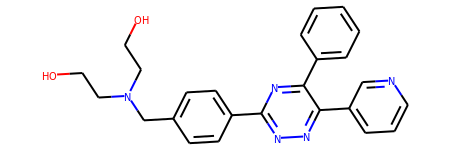

In [92]:
most_active_p1[0][0]

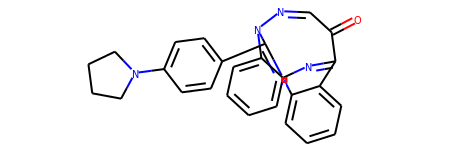

In [93]:
most_active_p1[1][0]

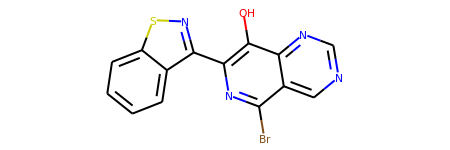

In [94]:
most_active_p2[0][0]

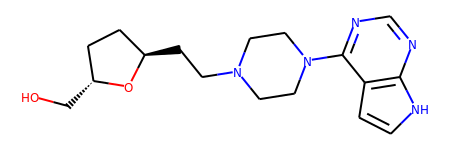

In [95]:
most_active_p2[1][0]

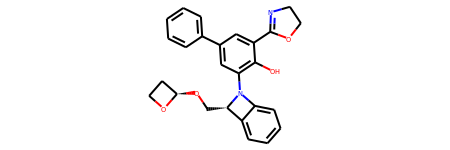

In [96]:
most_active_p3[0][0]

In [118]:
def num_unique(novel, existing):
    n_unique = len(set(novel + existing))
    n_total = len(novel + existing)
    
    are_unique = n_unique == n_total
    print(n_unique, n_total)
    return n_unique, are_unique

    
    

In [123]:
num_unique(va_df['SMILES'].values.tolist(), a_df['SMILES'].values.tolist())

1084 1566


(1084, False)

In [128]:
va_smiles = va_df['SMILES'].values.tolist()
a_smiles = a_df['SMILES'].values.tolist()
dl_smiles = dl_df['SMILES'].values.tolist()

In [125]:
len(va_smiles), len(a_smiles), len(va_smiles + a_smiles )

(482, 1084, 1566)

In [126]:
len(set(va_smiles)), len(set(a_smiles)), len(set(va_smiles + a_smiles ))

(482, 1084, 1084)

In [129]:
all(s in dl_smiles for s in va_smiles)

True

In [130]:
all(s in a_smiles for s in va_smiles)

True